In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Set the current working directory
import os
os.chdir('/content/drive/MyDrive/ml-verifier-oracle/training')
print("Current path: " + os.getcwd())

Mounted at /content/drive
Current path: /content/drive/MyDrive/ml-verifier-oracle/training


In [2]:
# import dependencies for training
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable

import tqdm

In [3]:
# load and inspect the dataset
# Read the CSV file
df = pd.read_csv('dataset10k20x20/forest_dataset.csv')

# Display the modified DataFrame
print(df)

                 imageT0             imageT1  label
0        forestT0_0.jpeg     forestT1_0.jpeg      0
1        forestT0_1.jpeg     forestT1_1.jpeg      0
2        forestT0_2.jpeg     forestT1_2.jpeg      0
3        forestT0_3.jpeg     forestT1_3.jpeg      0
4        forestT0_4.jpeg     forestT1_4.jpeg      0
...                  ...                 ...    ...
4995  forestT0_4995.jpeg  forestT1_4995.jpeg      1
4996  forestT0_4996.jpeg  forestT1_4996.jpeg      1
4997  forestT0_4997.jpeg  forestT1_4997.jpeg      1
4998  forestT0_4998.jpeg  forestT1_4998.jpeg      1
4999  forestT0_4999.jpeg  forestT1_4999.jpeg      1

[5000 rows x 3 columns]


In [4]:
os.chdir('/content/drive/MyDrive/ml-verifier-oracle/training/dataset10k20x20')
print("Current path: " + os.getcwd())

Current path: /content/drive/MyDrive/ml-verifier-oracle/training/dataset10k20x20


In [5]:
# Split the dataset into training and testing sets

image1_paths = df['imageT0'].tolist()
image2_paths = df['imageT1'].tolist()
labels = df['label'].tolist()


train_image1_paths, test_image1_paths, train_image2_paths, test_image2_paths, train_labels, test_labels = train_test_split(
    image1_paths, image2_paths, labels, test_size=0.2, random_state=42
)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [7]:
class ForestDataset(Dataset):
    def __init__(self, image1_paths, image2_paths, labels, transform=None):
        self.image1_paths = image1_paths
        self.image2_paths = image2_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img1 = Image.open(self.image1_paths[idx]).convert('L')
        img2 = Image.open(self.image2_paths[idx]).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)


        return img1, img2, label

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((10, 10)),
    transforms.ToTensor(),
])


# Create datasets and dataloaders
train_dataset = ForestDataset(train_image1_paths, train_image2_paths, train_labels, transform=transform)
test_dataset = ForestDataset(test_image1_paths, test_image2_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MODSiameseBambooNN(nn.Module):
    def __init__(self):
        super(MODSiameseBambooNN, self).__init__()
        self.embedding_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        # Calculate the size of the fully connected layer input based on the spatial dimensions
        self.fc_input_size = self.get_fc_input_size((1, 10, 10))
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 16)
        )
        self.out = nn.Linear(16, 1)  # Output 1 for similar, 0 for dissimilar

    def forward_one(self, x):
        x = x.view(-1, 1, 10, 10)  # Reshape input for convolutional layer
        return self.embedding_net(x)

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        distance = torch.abs(output1 - output2)
        embedded = self.fc(distance)
        output = self.out(embedded)
        return output

    def get_fc_input_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.embedding_net(x)
            return x.view(1, -1).size(1)


# Create instances of the models
siamese_mod = MODSiameseBambooNN()

# Print parameters for each layer
for name, param in siamese_mod.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")

# Count parameters in SiameseLeNet
mod_params = sum(p.numel() for p in siamese_mod.parameters())
print(f"Number of parameters in MODSiameseBambooNN: {mod_params}")


Layer: embedding_net.0.weight, Parameters: 144
Layer: embedding_net.0.bias, Parameters: 16
Layer: embedding_net.1.weight, Parameters: 16
Layer: embedding_net.1.bias, Parameters: 16
Layer: embedding_net.4.weight, Parameters: 4608
Layer: embedding_net.4.bias, Parameters: 32
Layer: embedding_net.5.weight, Parameters: 32
Layer: embedding_net.5.bias, Parameters: 32
Layer: fc.0.weight, Parameters: 8192
Layer: fc.0.bias, Parameters: 256
Layer: fc.3.weight, Parameters: 16384
Layer: fc.3.bias, Parameters: 64
Layer: fc.6.weight, Parameters: 1024
Layer: fc.6.bias, Parameters: 16
Layer: out.weight, Parameters: 16
Layer: out.bias, Parameters: 1
Number of parameters in MODSiameseBambooNN: 30849


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedSiameseBambooNN(nn.Module):
    def __init__(self):
        super(SimplifiedSiameseBambooNN, self).__init__()
        self.embedding_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten()
        )
        # Calculate the size of the fully connected layer input based on the spatial dimensions
        self.fc_input_size = self.get_fc_input_size((1, 8, 8))  # Adjusted spatial dimensions
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 16)
        )
        self.out = nn.Linear(16, 1)  # Output 1 for similar, 0 for dissimilar

    def forward_one(self, x):
        x = x.view(-1, 1, 10, 10)  # Reshape input for convolutional layer
        return self.embedding_net(x)

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        distance = torch.abs(output1 - output2)
        embedded = self.fc(distance)
        output = self.out(embedded)
        return output

    def get_fc_input_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.embedding_net(x)
            return x.view(1, -1).size(1)

# Create an instance of the simplified model
simplified_siamese_mod = SimplifiedSiameseBambooNN()

# Print parameters for each layer
for name, param in simplified_siamese_mod.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")

# Count parameters in the simplified model
simplified_mod_params = sum(p.numel() for p in simplified_siamese_mod.parameters())
print(f"Number of parameters in SimplifiedSiameseBambooNN: {simplified_mod_params}")


Layer: embedding_net.0.weight, Parameters: 72
Layer: embedding_net.0.bias, Parameters: 8
Layer: embedding_net.1.weight, Parameters: 8
Layer: embedding_net.1.bias, Parameters: 8
Layer: fc.0.weight, Parameters: 18432
Layer: fc.0.bias, Parameters: 64
Layer: fc.3.weight, Parameters: 1024
Layer: fc.3.bias, Parameters: 16
Layer: out.weight, Parameters: 16
Layer: out.bias, Parameters: 1
Number of parameters in SimplifiedSiameseBambooNN: 19649


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FinalSiameseBambooNN(nn.Module):
    def __init__(self):
        super(FinalSiameseBambooNN, self).__init__()
        self.embedding_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),  # Decrease filters in the Conv2d layer
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten()
        )
        # Calculate the size of the fully connected layer input based on the spatial dimensions
        self.fc_input_size = self.get_fc_input_size((1, 8, 8))  # Adjusted spatial dimensions
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),  # Adjusted units in the first Linear layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),  # Adjusted units in the second Linear layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16)
        )
        self.out = nn.Linear(16, 1)  # Output 1 for similar, 0 for dissimilar

    def forward_one(self, x):
        x = x.view(-1, 1, 10, 10)  # Reshape input for convolutional layer
        return self.embedding_net(x)

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        distance = torch.abs(output1 - output2)
        embedded = self.fc(distance)
        output = self.out(embedded)
        return output

    def get_fc_input_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.embedding_net(x)
            return x.view(1, -1).size(1)

# Create an instance of the final model
final_siamese_mod = FinalSiameseBambooNN()

# Print parameters for each layer
for name, param in final_siamese_mod.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")

# Count parameters in the final model
final_mod_params = sum(p.numel() for p in final_siamese_mod.parameters())
print(f"Number of parameters in FinalSiameseBambooNN: {final_mod_params}")


Layer: embedding_net.0.weight, Parameters: 72
Layer: embedding_net.0.bias, Parameters: 8
Layer: embedding_net.1.weight, Parameters: 8
Layer: embedding_net.1.bias, Parameters: 8
Layer: fc.0.weight, Parameters: 36864
Layer: fc.0.bias, Parameters: 128
Layer: fc.3.weight, Parameters: 4096
Layer: fc.3.bias, Parameters: 32
Layer: fc.6.weight, Parameters: 512
Layer: fc.6.bias, Parameters: 16
Layer: out.weight, Parameters: 16
Layer: out.bias, Parameters: 1
Number of parameters in FinalSiameseBambooNN: 41761


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FurtherAdjustedSiameseBambooNN(nn.Module):
    def __init__(self):
        super(FurtherAdjustedSiameseBambooNN, self).__init__()
        self.embedding_net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),  # Reduce filters in the first Conv2d layer
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten()
        )
        # Calculate the size of the fully connected layer input based on the spatial dimensions
        self.fc_input_size = self.get_fc_input_size((1, 10, 10))
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),  # Reduce units in the first Linear layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32)  # Reduce units in the second Linear layer
        )
        self.out = nn.Linear(32, 1)  # Output 1 for similar, 0 for dissimilar

    def forward_one(self, x):
        x = x.view(-1, 1, 10, 10)  # Reshape input for convolutional layer
        return self.embedding_net(x)

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        distance = torch.abs(output1 - output2)
        embedded = self.fc(distance)
        output = self.out(embedded)
        return output

    def get_fc_input_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.embedding_net(x)
            return x.view(1, -1).size(1)

# Create an instance of the further adjusted model
further_adjusted_siamese_mod = FurtherAdjustedSiameseBambooNN()

# Print parameters for each layer
for name, param in further_adjusted_siamese_mod.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")

# Count parameters in the further adjusted model
further_adjusted_mod_params = sum(p.numel() for p in further_adjusted_siamese_mod.parameters())
print(f"Number of parameters in FurtherAdjustedSiameseBambooNN: {further_adjusted_mod_params}")


Layer: embedding_net.0.weight, Parameters: 72
Layer: embedding_net.0.bias, Parameters: 8
Layer: embedding_net.1.weight, Parameters: 8
Layer: embedding_net.1.bias, Parameters: 8
Layer: fc.0.weight, Parameters: 65536
Layer: fc.0.bias, Parameters: 128
Layer: fc.3.weight, Parameters: 4096
Layer: fc.3.bias, Parameters: 32
Layer: out.weight, Parameters: 32
Layer: out.bias, Parameters: 1
Number of parameters in FurtherAdjustedSiameseBambooNN: 69921


In [9]:
# TRAIN THE MODEL
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
#from defineSNN import SiameseBambooNN
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FurtherAdjustedSiameseBambooNN().to(device)


# Display the network architecture
#print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

criterion = torch.nn.BCEWithLogitsLoss()
#criterion = ContrastiveLoss(margin=5)


# Training loop
num_epochs = 10
learning_rates = [10, 5, 2, 0.1, 0.01]
avg_losses = {lr: [] for lr in learning_rates}
accuracies = {lr: [] for lr in learning_rates}

for lr in learning_rates:

    #optimizer =  optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    #scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):

        total_loss = 0
        total_batches = 0
        model.train()

        for batch in train_loader:
            img1, img2, label = batch
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()
            finalout = model(img1, img2)
            output1 = model.forward_one(img1)
            output2 = model.forward_one(img2)

            labels = torch.zeros_like(finalout)
            labels[label.view(-1, 1) == 1] = 1
            loss = criterion(finalout, labels.float())
            #loss = criterion(output1, output2, label.float())


            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_batches += 1

        #scheduler.step()
        average_loss = total_loss / total_batches
        avg_losses[lr].append(average_loss)
        print(f'Learning Rate: {lr}, Avg loss: {average_loss}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for batch in test_loader:
            img1, img2, label = batch
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            finalout = model(img1, img2)
            predicted_labels = (torch.sigmoid(finalout) > 0.5).float()

            total += label.size(0)
            correct += (predicted_labels.view(-1) == label).sum().item()

        accuracy = correct / total
        accuracies[lr].append(accuracy)
        print(f'Learning Rate: {lr}, Test Accuracy: {accuracy * 100:.2f}%')


    # save just params
    torch.save(model.state_dict(), f'trained_simplesnn_lr_{lr}B.pth')


Total number of parameters: 69921
Learning Rate: 10, Avg loss: 0.6302226237952709
Learning Rate: 10, Avg loss: 0.38965247133746744
Learning Rate: 10, Avg loss: 0.20321277829119935
Learning Rate: 10, Avg loss: 0.14523006196133792
Learning Rate: 10, Avg loss: 0.11420845630695112
Learning Rate: 10, Avg loss: 0.10279642197507201
Learning Rate: 10, Avg loss: 0.09309509583268664
Learning Rate: 10, Avg loss: 0.07580702218809166
Learning Rate: 10, Avg loss: 0.07150438532058616
Learning Rate: 10, Avg loss: 0.0609294066743314
Learning Rate: 10, Test Accuracy: 94.80%
Learning Rate: 5, Avg loss: 0.05744528884089959
Learning Rate: 5, Avg loss: 0.05238493273009226
Learning Rate: 5, Avg loss: 0.05013219600667071
Learning Rate: 5, Avg loss: 0.04330117194565901
Learning Rate: 5, Avg loss: 0.04066413393969924
Learning Rate: 5, Avg loss: 0.038581103216183694
Learning Rate: 5, Avg loss: 0.03359184109272974
Learning Rate: 5, Avg loss: 0.031817176913964434
Learning Rate: 5, Avg loss: 0.03276245285850564
Lea

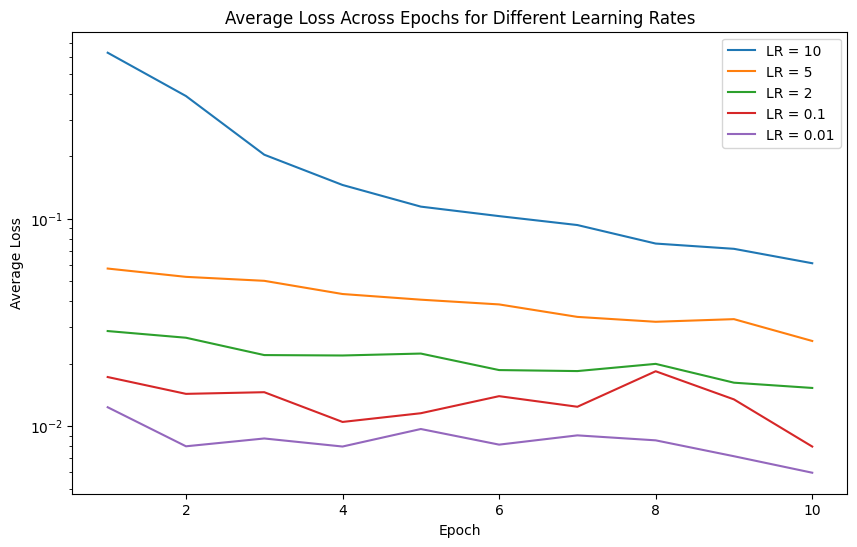

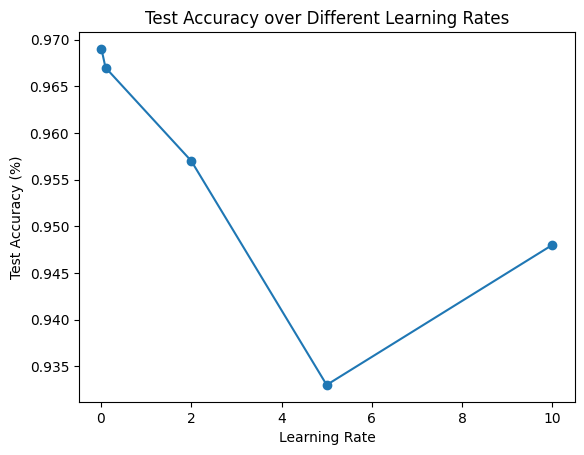

In [10]:
# Plotting the average loss for each learning rate
plt.figure(figsize=(10, 6))
for lr, losses in avg_losses.items():
    plt.plot(range(1, num_epochs + 1), losses, label=f'LR = {lr}')

plt.title('Average Loss Across Epochs for Different Learning Rates')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Average Loss')
plt.legend()
# Set axis limits
#plt.xlim(1, 8)
#plt.ylim(0, 4)
plt.show()

# Plotting accuracies over learning rates
lr_values = [lr for lr in learning_rates]
accuracy_values = [accuracies[lr][-1] for lr in learning_rates]
plt.plot(lr_values, accuracy_values, marker='o', linestyle='-')
#plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Different Learning Rates')
plt.show()